In [12]:
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(rms))
suppressMessages(library(StatsBombR))

In [13]:
event_data <- StatsBombFreeEvents()

[1] "Whilst we are keen to share data and facilitate research, we also urge you to be responsible with the data. Please register your details on https://www.statsbomb.com/resource-centre and read our User Agreement carefully."
[1] "Whilst we are keen to share data and facilitate research, we also urge you to be responsible with the data. Please register your details on https://www.statsbomb.com/resource-centre and read our User Agreement carefully."
[1] "Whilst we are keen to share data and facilitate research, we also urge you to be responsible with the data. Please register your details on https://www.statsbomb.com/resource-centre and read our User Agreement carefully."


In [14]:
passes_unclean <- event_data %>% filter(type.name == "Pass") %>% filter(pass.outcome.name %in% c(NA, "Incomplete", "Out"))
passes_unclean$under_pressure <- ifelse(is.na(passes_unclean$under_pressure), FALSE, TRUE)

passes_unclean$start_x <- NA
passes_unclean$start_y <- NA
passes_unclean$end_x <- NA
passes_unclean$end_y <- NA

for(r in 1:nrow(passes_unclean)) {
    start_loc <- unlist(passes_unclean$location[r])
    passes_unclean$start_x[r] <- start_loc[1]
    passes_unclean$start_y[r] <- start_loc[2]
    end_loc <- unlist(passes_unclean$pass.end_location[r])
    passes_unclean$end_x[r] <- end_loc[1]
    passes_unclean$end_y[r] <- end_loc[2]
}

passes_unclean <- passes_unclean %>% filter(is.na(pass.type.name))
passes_unclean$pass.outcome <- ifelse(passes_unclean$pass.outcome.name %in% c("Incomplete", "Out"), 0, 1)
passes_clean <- passes_unclean %>% select(player.id, player.name, position.name, start_x, start_y, duration, under_pressure, pass.length, pass.angle, pass.height.name, pass.body_part.name, end_x, end_y, pass.outcome)

positions <- passes_clean$position.name
mapping <- data.frame(position = unique(passes_clean$position.name),
                     abbrev = c('FW', 'W', 'CB', 'W', 'FB', 'CM', 'FW', 'CM', 'CF', 'CB', 'CM', 'W', 'CB', 'GK', 'FB', 'W', 'FW', 'CDM', 'CDM', 'CAM', 'CDM', 'CAM', 'CAM', 'FB', 'FB'))
passes_clean$position.name <- factor(positions,levels = mapping$position,labels = mapping$abbrev)

In [15]:
head(passes_clean)

player.id,player.name,position.name,start_x,start_y,duration,under_pressure,pass.length,pass.angle,pass.height.name,pass.body_part.name,end_x,end_y,pass.outcome
4659,Ramona Bachmann,FW,69,33,1.640,TRUE,31.764761,-1.0789871,Low Pass,Right Foot,84,5,1
4654,Nikita Parris,W,58,76,1.506,FALSE,17.720045,-0.2860514,High Pass,Right Foot,75,71,1
4657,Anita Amma Ankyewah Asante,CB,44,17,3.453,FALSE,51.351727,0.1171087,High Pass,Right Foot,95,23,1
4657,Anita Amma Ankyewah Asante,CB,54,24,0.560,TRUE,2.236068,2.0344439,Ground Pass,Right Foot,53,26,0
4635,Julia Spetsmark,W,92,26,2.080,FALSE,21.377558,-1.3825748,Ground Pass,Left Foot,96,5,1
4651,Demi Stokes,FB,95,5,0.760,TRUE,13.601471,2.1995926,Ground Pass,Left Foot,87,16,1


In [16]:
model <- glm(pass.outcome ~ duration + pass.length + under_pressure + duration:pass.length + start_x + end_x + start_x:end_x + pass.height.name + position.name + position.name:pass.height.name + position.name:pass.length + pass.body_part.name, data = passes_clean, family=binomial())

summary(model)

passes_clean$pred <- predict(model, passes_clean, type = "response")

passes_clean <- passes_clean %>% na.omit()


Call:
glm(formula = pass.outcome ~ duration + pass.length + under_pressure + 
    duration:pass.length + start_x + end_x + start_x:end_x + 
    pass.height.name + position.name + position.name:pass.height.name + 
    position.name:pass.length + pass.body_part.name, family = binomial(), 
    data = passes_clean)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.5292  -0.5422   0.3503   0.6335   3.3158  

Coefficients:
                                             Estimate Std. Error z value
(Intercept)                                -1.155e+00  3.081e-01  -3.749
duration                                    3.322e-01  4.537e-02   7.321
pass.length                                 7.310e-02  6.750e-03  10.830
under_pressureTRUE                         -8.057e-02  4.548e-02  -1.772
start_x                                     1.105e-01  3.381e-03  32.694
end_x                                      -4.704e-02  2.407e-03 -19.541
pass.height.nameHigh Pass                  -1.

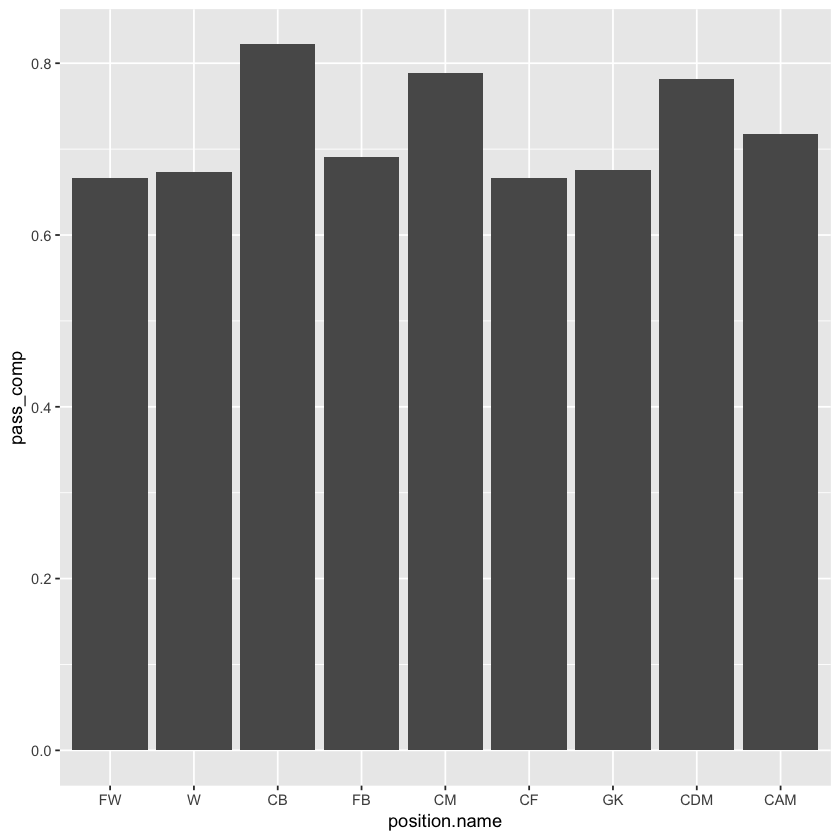

In [17]:
passes_clean %>% 
group_by(position.name) %>% 
summarise(pass_comp = mean(pass.outcome)) %>% 
ggplot(aes(x = position.name, y = pass_comp)) +
    geom_bar(stat = "identity")

In [18]:
player_passing <- passes_clean %>% group_by(player.name) %>% summarise(pass_comp = mean(pass.outcome), avg_pass_comp = mean(pred), passes = n()) %>% filter(passes > 200) %>% mutate(diff = pass_comp - avg_pass_comp) %>% arrange(-diff)
players <- player_passing$player.name
passes_clean <- passes_clean %>% filter(player.name %in% players)

In [19]:
pass_actual_boot <- passes_clean %>%
group_by(player.name) %>%
  do(data.frame(rbind(smean.cl.boot(.$pass.outcome,B=2000))))

pass_pred_boot <- passes_clean %>%
group_by(player.name) %>%
  do(data.frame(rbind(smean.cl.boot(.$pred,B=2000))))

In [20]:
names(pass_actual_boot) <- c("player", "mean_pass_comp", "mean_lower_pass_comp", "mean_upper_pass_comp")
names(pass_pred_boot) <- c("player", "mean_pred_pass_comp", "mean_lower_pred_pass_comp", "mean_upper_pred_pass_comp")
passing <- merge(pass_actual_boot, pass_pred_boot, by = c("player"))

In [21]:
passing$sig <- ifelse(passing$mean_pass_comp < passing$mean_lower_pred_pass_comp, 1,
                     ifelse(passing$mean_pass_comp > passing$mean_upper_pred_pass_comp, 1, 0))
passing$est_diff <- passing$mean_pass_comp - passing$mean_pred_pass_comp

In [22]:
passing %>% arrange(est_diff)

player,mean_pass_comp,mean_lower_pass_comp,mean_upper_pass_comp,mean_pred_pass_comp,mean_lower_pred_pass_comp,mean_upper_pred_pass_comp,sig,est_diff
Rebecca Quinn,0.7649770,0.7050691,0.8202765,0.8281063,0.7997468,0.8557974,1,-0.063129293
Jaelene Hinkle,0.5946970,0.5340909,0.6515152,0.6467507,0.6134948,0.6803050,1,-0.052053712
Merritt Mathias,0.6324786,0.5683761,0.6923077,0.6764894,0.6432492,0.7098396,1,-0.044010745
Katrina Gorry,0.7231834,0.6678201,0.7750865,0.7544401,0.7255078,0.7818693,1,-0.031256709
Alanna Kennedy,0.7716535,0.7204724,0.8188976,0.7986778,0.7711030,0.8232539,0,-0.027024248
Emily van Egmond,0.6756757,0.6171171,0.7387387,0.6979755,0.6637749,0.7317094,0,-0.022299797
Lauren Barnes,0.7489879,0.6923077,0.8016194,0.7676646,0.7348009,0.8017454,0,-0.018676740
Débora Cristiane de Oliveira,0.6551724,0.6015326,0.7126437,0.6718818,0.6422032,0.7003511,0,-0.016709416
Sarah Killion,0.8070866,0.7597441,0.8543307,0.8076957,0.7837978,0.8293744,0,-0.000609091
Megan Oyster,0.7860697,0.7313433,0.8407960,0.7816237,0.7451830,0.8171922,0,0.004445989
